# Analysis of GPS disturbances in Norway

In [1]:
%pip install geopandas

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.0/24.0 MB 51.9 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.6/9.6 MB 53.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 64.0 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.


In [12]:
%pip install wikipedia

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for wikipedia: filename=wikipedia-1.4.0-py3-none-any.whl size=11758 sha256=821e6719f565b81bba9df42a6c6a287e8247223363a4ce391819ef3393c45bf9
  Stored in directory: /home/codespace/.cache/pip/wheels/63/47/7c/a9688349aa74d228ce0a9023229c6c0ac52ca2a40fe87679b8
Successfully built wikipedia
Note: you may need to restart the kernel to use updated packages.


In [1]:
import pandas as pd
import geopandas
import matplotlib.pyplot as plt
import wikipedia
from shapely.geometry import Polygon, LineString, Point


Get the global list of airports used for openflights.org. This is made available under the [Open Database License](https://opendatacommons.org/licenses/odbl/1-0/).

In [2]:
airports_path=\
'https://raw.githubusercontent.com/jpatokal/openflights/refs/heads/master/data/airports.dat'
airports_df=pd.read_csv(airports_path,
                        header=None,
                        names=['Airport_ID','airport_name','city','country',
                               'iata','icao','lat','lon','altitude','Timezone',
                               'DST','Tz','type','source'],
                        na_values='\\N',
                        on_bad_lines='warn')

Article from Barents observer lists Finnmark airports with problematic GPS performance.
https://www.thebarentsobserver.com/security/russian-jamming-is-now-messing-up-gps-signals-for-norwegian-aviation-practically-every-day/163663

> GPS jamming reports are coming from pilots on the airliners SAS, Norwegian and Widerøe as well as civilian air ambulances flying in and out of Kirkenes airport and the smaller airports along the coast of Finnmark, like Vadsø, Vardø, Båtsfjord, Berlevåg and Mehamn.

Note that the Norwegian placenames have special non-ascii characters.

In [3]:
airports_df[airports_df.country=='Norway']

,Airport_ID,airport_name,city,country,iata,icao,lat,lon,altitude,Timezone,DST,Tz,type,source
621,630,Ålesund Airport,Alesund,Norway,AES,ENAL,62.562500,6.119700,69,1.0,E,Europe/Oslo,airport,OurAirports
622,631,Andøya Airport,Andoya,Norway,ANX,ENAN,69.292503,16.144199,43,1.0,E,Europe/Oslo,airport,OurAirports
623,632,Alta Airport,Alta,Norway,ALF,ENAT,69.976097,23.371700,9,1.0,E,Europe/Oslo,airport,OurAirports
624,633,Bømoen Airport,Voss,Norway,NaN,ENBM,60.638901,6.501500,300,1.0,E,Europe/Oslo,airport,OurAirports
625,634,Brønnøysund Airport,Bronnoysund,Norway,BNN,ENBN,65.461098,12.217500,25,1.0,E,Europe/Oslo,airport,OurAirports
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5841,7872,Ringebu Airfield Frya,Frya,Norway,NaN,ENRI,61.545441,10.061588,571,1.0,E,Europe/Oslo,airport,OurAirports
6534,9255,Rakkestad Astorp Airport,Rakkestad,Norway,NaN,ENRK,59.397499,11.346900,400,1.0,E,Europe/Oslo,airport,OurAirports
6712,10080,Kautokeino Air Base,Kautokeino,Norway,QKX,ENKA,69.040298,23.034000,1165,1.0,U,NaN,airport,OurAirports
7490,13416,Pyramiden Heliport,Pyramiden,Norway,NaN,ENPY,78.652322,16.337208,6,1.0,E,NaN,airport,OurAirports


Note that in the airports data, the airport name has the special characters, whereas the city names are in the nearest ascii characters.

In [4]:
affected_list='Kirkenes|Vadsø|Vardø|Båtsfjord|Berlevåg|Mehamn'
norway_df=airports_df.query("airport_name.str.contains('"+affected_list+"')")

In [5]:
norway_gdf=geopandas.GeoDataFrame(norway_df, 
                       geometry=geopandas.points_from_xy(norway_df.lon, 
                                                         norway_df.lat), 
                       crs="EPSG:4326")

In [6]:
air_base=wikipedia.page("Olenya_air_base").coordinates

In [7]:
air_base_df=pd.DataFrame({'airport':'Olenya_base','latitude':float(air_base[0]),'longitude':float(air_base[1])},index=[0])

In [8]:
air_base_gdf=geopandas.GeoDataFrame(air_base_df, 
                       geometry=geopandas.points_from_xy(air_base_df.longitude,
                                                         air_base_df.latitude),
                       crs="EPSG:4326")

In [9]:
countries="https://naciscdn.org/naturalearth/10m/cultural/ne_10m_admin_0_countries.zip"
world = (geopandas
         .read_file(countries)
         .clip([3, 63, 42, 72]).dropna(axis='columns',how='all')
        )

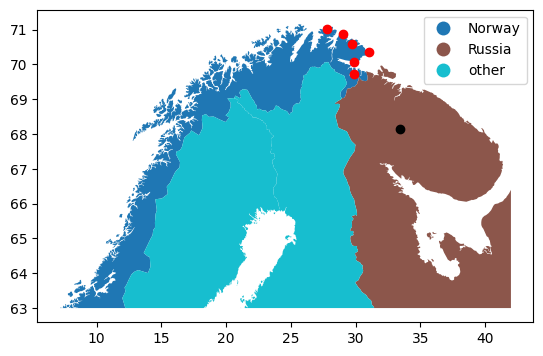

In [10]:
ax = (world
 .assign(
     colour= world.SOVEREIGNT.where(world.SOVEREIGNT.str.match('Norway') | 
                                    world.SOVEREIGNT.str.match('Russia'),
                                    'other')
 )
).plot(column='colour',legend=True)
norway_gdf.plot(ax=ax,color='red')
air_base_gdf.plot(ax=ax,color='black')
plt.show()

In [29]:
world_polar = (geopandas
         .read_file(countries)
         .clip([-180, 55, 180, 90])#.dropna(axis='columns',how='all')
        )

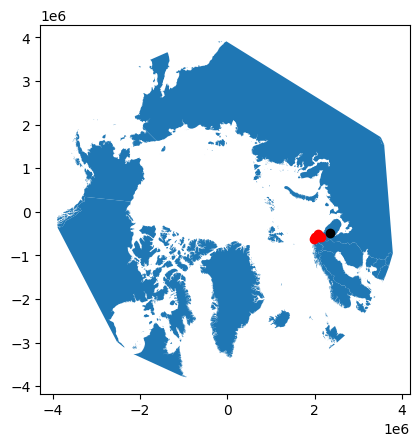

In [30]:
ax = world_polar.to_crs(3413).plot()
norway_gdf.to_crs(3413).plot(ax=ax,color='red')
air_base_gdf.to_crs(3413).plot(ax=ax,color='black')

plt.show()

Map showing the Norwegian airports suffering from GNSS interference as red dots, and the Russian airbase which is a possible source of interference, overlayed on a map of the border area between Norway, Russia, Sweden and Finland.  

Summarising "High North, high drama" article by Isabel Hilton in Prospect magazine October 2024:
- In May 2023 Ukrainian drones hit the Engels airbase near Saratov which was used by long range bombers
- In response to the drone attack, the bombers were relocated to the Olenya base on the Kola Peninsula near the border with Finland and Norway, while still being used in the war in Ukraine.
- on 27th July (2024 according to [Wikipedia](https://en.wikipedia.org/wiki/Olenya_air_base#Russo-Ukrainian_War) which quotes the [Barents observer again](https://www.thebarentsobserver.com/security/ukrainian-drone-hit-tu22m3-bomber-at-olenya-airfield-intel-report-claims/166511)) there was a ukrainian drone attack on the Olenya base. The GPS interference must be part of the drone countermeasures at the base, and was already in place before this drone attack according to the Barents observer.  

This analysis is available in my Github repository https://github.com/stelios-c/GPS_analysis

In [11]:
norway_gdf.geometry.distance(Point((air_base_df.longitude, air_base_df.latitude)))
                       #crs="EPSG:4326"))

/tmp/ipykernel_515/4169619940.py:1: UserWarning: Geometry is in a geographic CRS. Results from 'distance' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  norway_gdf.geometry.distance(Point((air_base_df.longitude, air_base_df.latitude)))


628     4.498538
640     3.905026
4062    6.330364
4063    4.094944
4080    5.198935
4294    3.273121
dtype: float64